## 3.7 ガウス過程回帰モデル：尤度の一般化

### 3.7.1 モデル概要
$$
\begin{align*}
    p(y) = \int {p(y|f)p(f)\text{d}f} \\
    p(f) = \text{GP}(m(x), k(x, x'))
\end{align*}
$$

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, UnwhitenedVariationalStrategy
import torch

sns.set()

### 3.7.2 実装

$$
\begin{align*}
    p(y) &= \int {p(y|f)p(f)\text{d}f} \\
    p(f) &= \text{GP}(m(x), k(x, x')) \\
    p(y|f) &= \text{Bern}(y | \theta = \text{sigmoid}(f))
\end{align*}
$$


/var/folders/rj/lgv8bfcx63q2n09cr87df55c0000gn/T/ipykernel_53162/3375375994.py:13: RuntimeWarning: covariance is not positive-semidefinite.
  f = np.random.multivariate_normal(mean=np.zeros(grid_N ** 2), cov=K)
/var/folders/rj/lgv8bfcx63q2n09cr87df55c0000gn/T/ipykernel_53162/3375375994.py:38: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(image)


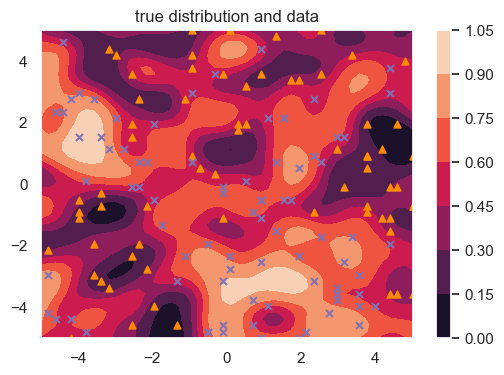

In [5]:
# 格子点数
grid_N = 50

# 2 次元格子点作成
x = np.linspace(-5.0, 5.0, grid_N)
X1_grid, X2_grid = np.meshgrid(x, x)
X12_grid = np.array([[x1, x2] for x1, x2 in zip(X1_grid.ravel(), X2_grid.ravel())])
X12_grid = torch.from_numpy(X12_grid).float()

# ガウス過程でデータ生成
kernel = gpytorch.kernels.RBFKernel()
K = kernel.forward(X12_grid, X12_grid).detach().numpy()
f = np.random.multivariate_normal(mean=np.zeros(grid_N ** 2), cov=K)

# シグモイド関数
sigmoid = lambda x: 1 / (1 + np.exp(-x))
Y = sigmoid(f)
Y_grid = Y.reshape(grid_N, grid_N)

# 閾値で 2値化
threshold = lambda x: 1 if x >= 0.5 else 0
Y_binary_grid = torch.tensor(list(map(threshold, Y)))

# 学習用にデータをサンプリング
N = 150
sample_index = np.random.choice(np.arange(grid_N ** 2), N)
x_data = X12_grid[sample_index].clone().float()
y_data = Y_binary_grid[sample_index].clone().float()

fig, ax = plt.subplots(figsize=(6, 4))
image = ax.contourf(X1_grid, X2_grid, Y_grid)

# データ点をプロット
x_data_1 = x_data[y_data == 0]
x_data_2 = x_data[y_data == 1]
ax.scatter(x=x_data_1[:, 0], y=x_data_1[:, 1], color="darkorange", marker="^", s=25)
ax.scatter(x=x_data_2[:, 0], y=x_data_2[:, 1], color="m", marker="x", s=25)
plt.colorbar(image)
ax.set_title("true distribution and data")
plt.show()

In [7]:
# https://docs.gpytorch.ai/en/stable/examples/04_Variational_and_Approximate_GPs/index.html
# ガウス過程回帰モデルの実装
class GPClassificationModel(ApproximateGP):
    def __init__(self, train_x):
        # 誘導点における関数値の変分近似分布を設定
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))

        # 学習データを補助入力点として使用する場合に高速な UnwhitenedVariationalStrategy を使用
        # 学習データが多い場合は誘導点を用意して標準の VariationalStrategy を設定することが望ましい.
        variational_strategy = UnwhitenedVariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(GPClassificationModel, self).__init__(variational_strategy)

        # 平均関数
        self.mean_module = gpytorch.means.ConstantMean()

        # カーネル関数 (2 次元に拡張)
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(2))

    # ガウス過程の生成過程
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# データを設定しモデルを定義
model = GPClassificationModel(x_data)

# 尤度にベルヌーイ分布を設定
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

In [8]:
# 学習モードに設定
model.train()
likelihood.train()

# モデルのハイパーパラメータを全て最適化することもできるが, この場合には過剰適合に注意する必要があるので
# 下記では, RBF カーネルのハイパーパラメータが既知であるとして最適化対象外とする.
# RBF カーネルのパラメータを固定する
model.covar_module.base_kernel.lengthscale = torch.tensor([0.6931, 0.6931])

# 最適化対象パラメータからRBFカーネルのパラメータを削除
all_params = set(model.parameters())
fix_params = {model.covar_module.base_kernel.raw_lengthscale}
opt_params = list(all_params - fix_params)

# 最適化するパラメータを Adam に渡す.
optimizer = torch.optim.Adam(opt_params, lr=0.1)

# 損失関数に ELBO の負値を設定
mll = gpytorch.mlls.VariationalELBO(likelihood, model, y_data.numel())

training_iter = 200
loss_list = []
for i in range(training_iter):
    # 勾配を 0 に初期化
    optimizer.zero_grad()

    # モデルからの出力
    output = model(x_data)

    # 損失関数の計算
    loss = - mll(output, y_data)

    # 勾配計算
    loss.backward()
    loss_list.append(loss.item())

    # パラメータ計算
    optimizer.step()

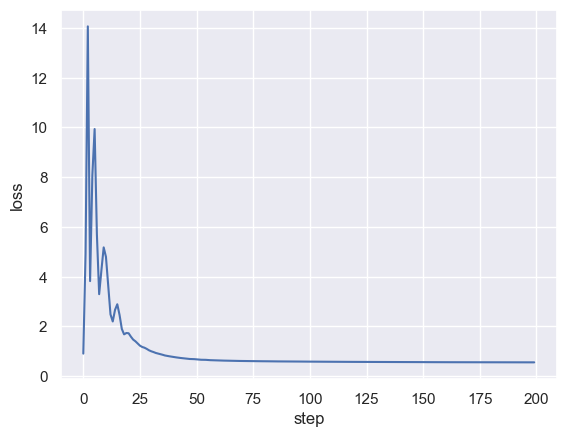

In [10]:
plt.plot(loss_list)
plt.xlabel("step")
plt.ylabel("loss")
plt.show()

/var/folders/rj/lgv8bfcx63q2n09cr87df55c0000gn/T/ipykernel_53162/1281101035.py:36: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(image1, ax=ax[0])
/var/folders/rj/lgv8bfcx63q2n09cr87df55c0000gn/T/ipykernel_53162/1281101035.py:37: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(image2, ax=ax[1])
/var/folders/rj/lgv8bfcx63q2n09cr87df55c0000gn/T/ipykernel_53162/1281101035.py:38: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(image3, ax=ax[2])


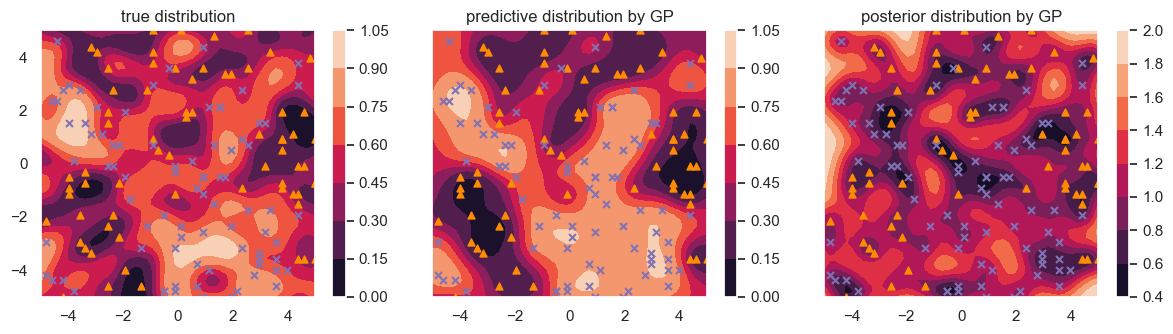

In [14]:
# 推論モードに設定
model.eval()
likelihood.eval()

with torch.no_grad():
    # 予測分布の出力
    f_dist = model(X12_grid)

    # 予測分布の平均
    mean = f_dist.mean

    # 信用区間の出力
    f_lower, f_upper = f_dist.confidence_region()

    # 尤度にパラメータとして入力
    y_dist = likelihood(f_dist)

fig, ax = plt.subplots(figsize=(12, 3.5), ncols=3, sharex=True, sharey=True)

# 真の関数の等高線図
image1 = ax[0].contourf(X1_grid, X2_grid, Y_grid)

# 予測分布平均の等高線図
image2 = ax[1].contourf(X1_grid, X2_grid, y_dist.mean.numpy().reshape(grid_N, grid_N))

# 予測分布共分散行列の対角要素の等高線図
image3 = ax[2].contourf(X1_grid, X2_grid, f_dist.covariance_matrix.diag().detach().numpy().reshape(grid_N, grid_N))

for i in range(3):
    ax[i].scatter(x=x_data_1[:, 0], y=x_data_1[:, 1], color="darkorange", marker="^", s=25)
    ax[i].scatter(x=x_data_2[:, 0], y=x_data_2[:, 1], color="m", marker="x", s=25)

ax[0].set_title("true distribution")
ax[1].set_title("predictive distribution by GP")
ax[2].set_title("posterior distribution by GP")
plt.colorbar(image1, ax=ax[0])
plt.colorbar(image2, ax=ax[1])
plt.colorbar(image3, ax=ax[2])
plt.tight_layout()
plt.show()